## License 

Copyright 2019 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

DISCLAIMER: <font color='red'>This notebook is not legal compliance advice.</font>

# Increase Fairness in Your Machine Learning Project with Disparate Impact Analysis using Python and H2O

#### Assess if your machine learning model is treating different groups of people similarly or differently

Fairness is an incredibly important, but highly complex entity. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle *observational* fairness, or how your model predictions affect different groups of people. This procedure is known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. If it’s good enough for multibillion-dollar credit portfolios, it’s probably good enough for your project. 

This example DIA notebook starts by training a gradient boosting machine (GBM) classifier on the UCI credit card default data using the popular open source library, h2o. A probability cutoff for making credit decisions is selected by maximizing the F1 statistic and confusion matrices are generated to summarize the GBM’s decisions across customers with different education levels. A basic DIA procedure is then conducted using the information stored in the confusion matrices. 

For an excellent and free reference on the topics of fairness and machine learning be sure to follow the book being written by Solon Barocas, Moritz Hardt and Arvind Narayanan: https://fairmlbook.org/. 

For Python fairness libraries that go far beyond the scope of this notebook see: 
* aequitas: https://github.com/dssg/aequitas
* AI Fairness 360: http://aif360.mybluemix.net/
* Themis: https://github.com/LASER-UMASS/Themis

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in-notebook
%matplotlib inline   

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 1, but the server still needs to be started.

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmps1i2ih_7
  JVM stdout: /tmp/tmps1i2ih_7/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmps1i2ih_7/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,5 months and 3 days !!!
H2O cluster name:,H2O_from_python_patrickh_i577ww
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

/home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In h2o, a numeric variable can be treated as numeric or categorical. The target variable `DEFAULT_NEXT_MONTH` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [6]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics
The h2o `describe()` function displays a brief description of the credit card default data. For the categorical input variables `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, and `PAY_0`-`PAY_6`, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs. Also, it's easy to see there are no missing values in this dataset, which will be an important consideration for calculating LOCO values in section 5 and 6.

In [7]:
data[X + [y]].describe()

Rows:30000
Cols:24




,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations. 

In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     #balance_classes=True, # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     model_id='dia_gbm',    # for locating the model in Flow UI 
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


#### Display variable importance
During training, the h2o GBM aggregates the improvement in error caused by each split in each decision tree across all the decision trees in the ensemble classifier. These values are attributed to the input variable used in each split and give an indication of the contribution each input variable makes toward the model's predictions. The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, a customer's most recent payment behavior, `PAY_0`, is by far the most important variable followed by their second most recent payment, `PAY_2`, and third most recent payment, `PAY_3`, behavior. This result is well-aligned with business practices in credit lending: people who miss their most recent payments are likely to default soon.

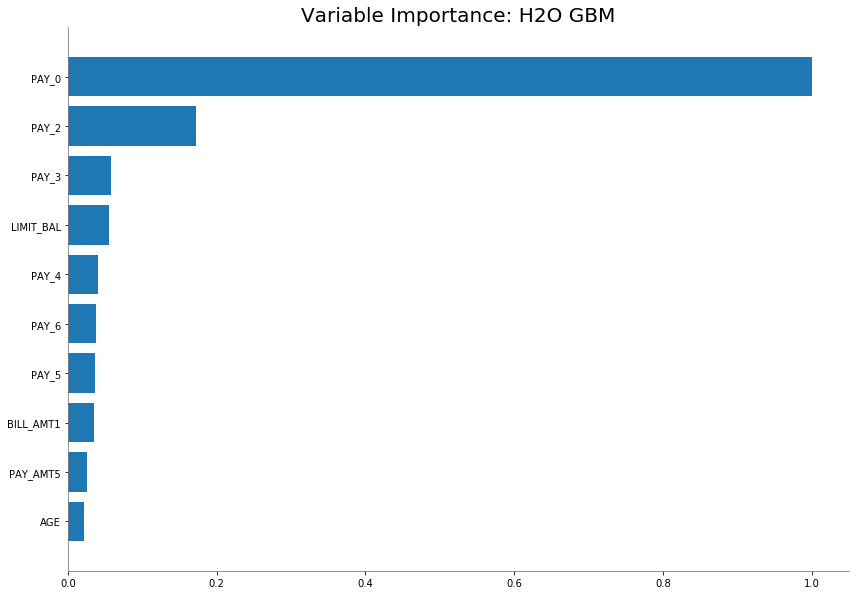

In [10]:
model.varimp_plot()

In sections below this notebook will assess whether the GBM is making disparate predictions for customers across educational levels. For now, it's a somewhat heartening sign that the GBM is not placing high importance on the `EDUCATION` variable.

#### Bind model predictions to test data for further calculations

In [11]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat]).as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


# 3. Select a Probability Cutoff by Maximizing F1 Statistic

#### Function to calculate AUC-PR Curve

Predictive models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one customer, you must specify a numeric cutoff above which we say a customer will default and below which we say they will not default. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remdiation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic.  

Selecting a cutoff can be done intervactively with h2o Flow as well. Enter the url: http://localhost:54321/flow/index.html (or your H2O Connection URL displayed in cell 2) into your browser. Select `Models` -> `List all models` -> `dia_gbm` and you should see an interactive ROC curve where you can pick your own cutoff.

To learn more about confusion matrices see: https://en.wikipedia.org/wiki/Confusion_matrix.

In [12]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame
        
prroc_frame = get_prroc(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH')

#### Select best cutoff

In [13]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
print('%.2f' % best_cut)

0.21


#### Plot AUC-PR Curve

An area under the curve for precision and recall (AUC-PR) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.

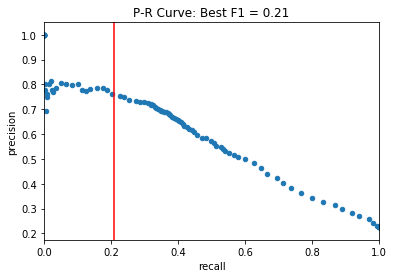

In [14]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

In h2o Flow a traditional ROC curve is displayed, in which true positive rate is plotted against false positive rate. You can still use h2o Flow and the traditional ROC curve to verify that F1 is maximized at a probability cutoff of ~ 0.21.

# 4. Report Raw Confusion Matrices

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across eduction levels.

#### Function to print confusion matrices by an input variable

In [15]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1253,750
predicted: 0,1334,5603


The general confusion matrix shows that the GBM is more accurate than not because the true positive and true negative cells contain the largest values by far. But the GBM seems to make a large number of type II errors or false negative predictions. False negatives are a known disparity issue, because for complex reasons, many credit scoring and other models tend to underestimate the likelihood a reference group - typically white males - to default. This is both a sociological fairness problem and a financial problem if a priviledged group is getting loans they don't really deserve and can't pay back.

#### Report confusion matrices by education level 

Because race is unavailable in the UCI credit card data set, `EDUCATION` level will be used to perform DIA. Note that while education level can be indicative of race, gender, or other protected-by-regulation attributes, DIA would typically be performed directly on race or gender. 

There are four `EDUCATION` levels in the data set:

In [16]:
ed_levels = list(test_yhat['EDUCATION'].unique())
ed_levels

['university', 'high school', 'graduate school', 'other']

#### Confusion matrix for `Education = other`

In [17]:
other_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='other', cutoff=best_cut)
other_cm

Confusion matrix by EDUCATION=other


,actual: 1,actual: 0
predicted: 1,2,9
predicted: 0,6,116


#### Confusion matrix for `Education = high school`

In [18]:
hs_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='high school', cutoff=best_cut)
hs_cm

Confusion matrix by EDUCATION=high school


,actual: 1,actual: 0
predicted: 1,253,102
predicted: 0,280,831


#### Confusion matrix for `Education = university`

In [19]:
uni_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='university', cutoff=best_cut)
uni_cm

Confusion matrix by EDUCATION=university


,actual: 1,actual: 0
predicted: 1,633,388
predicted: 0,655,2515


#### Confusion matrix for `Education = graduate school`

In [20]:
gs_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='graduate school', cutoff=best_cut)
gs_cm

Confusion matrix by EDUCATION=graduate school


,actual: 1,actual: 0
predicted: 1,365,251
predicted: 0,393,2141


# 6. Disparate Impact Analysis (DIA)

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

* Default correctly
* Non-default correctly
* Default incorrectly (type I errors)
* Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.

#### Dictionary of metrics used to assess parity

In [21]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
#'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Utility function to translate metrics into Pandas statements

In [22]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression


#### Calculate and report metrics
This nested loop calculates all the metrics defined above for each education level.

In [23]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'other': other_cm, 
           'high school': hs_cm, 
           'university': uni_cm, 
           'graduate school': gs_cm} 

metrics_frame = pd.DataFrame(index=ed_levels) # frame for metrics

# nested loop through:
# - education levels
# - metrics 
for level in ed_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
university,0.751133,0.491460,0.619980,0.866345,0.793375,0.133655,0.380020,0.508540,0.206625
high school,0.739427,0.474672,0.712676,0.890675,0.747975,0.109325,0.287324,0.525328,0.252025
graduate school,0.795556,0.481530,0.592532,0.895067,0.844909,0.104933,0.407468,0.518470,0.155091
other,0.887218,0.250000,0.181818,0.928000,0.950820,0.072000,0.818182,0.750000,0.049180


From eyeballing the raw metrics we can start to see a few potential disparity problems, particularly related to customers with `EDUCATION = other`. This is the smallest group in the data set, so it's not totally surprising that the GBM may struggle to treat it appropriately. 

#### Plot false negative rate by education level 

Customers with `EDUCATION = other` is a small group with a low default prevalence (0.06), and the GBM appears to underestimate the probability of default for these customers. They have a low true positive rate (0.25), a high specificity (or true negative rate) (0.92), a low false positive rate (0.072) and a high false negative rate (0.75). As dicussed above, false negatives are known to be potentially problematic from a fairness perspective and can be costly for the lender. (Of course other metrics are also important from a fairness and business perspective. Only false negative rate is plotted and discussed here for brevity's sake. For an excellent in-depth discussion and example regarding numerous disparity metrics, see: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)

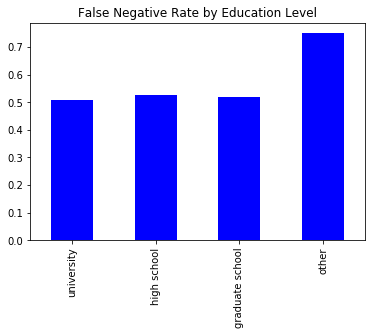

In [24]:
_ = metrics_frame['False Negative Rate'].plot(kind='bar', color='b', title='False Negative Rate by Education Level')

#### Calculate and report disparity
To calculate disparity we compare the confusion matrix for each education level to the metrics for a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem least likely to default as the reference level, i.e. `EDUCATION = graduate school`. (Usually the reference level would be `race = white` or `sex = male`.) We set thresholds such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. 

In [25]:
ref_level = 'graduate school' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=ed_levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
university,0.944162,1.02062,1.04632,0.967911,0.939007,1.27371,0.932638,0.980849,1.33228
high school,0.929447,0.985757,1.20276,0.995093,0.885272,1.04185,0.705146,1.01323,1.62502
graduate school,1,1,1,1,1,1,1,1,1
other,1.11522,0.519178,0.306849,1.03679,1.12535,0.686151,2.00797,1.44656,0.317107


For the selected thresholds, the GBM appears to have only a few disparate values for metrics for university and high school graduates as compared to customers who attended graduate school. Those disparities appear larger in magnitude for high school graduates than for university graduates. However, the GBM has numerous disparate values for metrics of customers who have an education level of `other`. These customers have high out-of-range values for false discovery rate disparity and false negative rate disparity, and have low out-of-range disparity values for several other metrics.

#### Plot false negative rate disparity

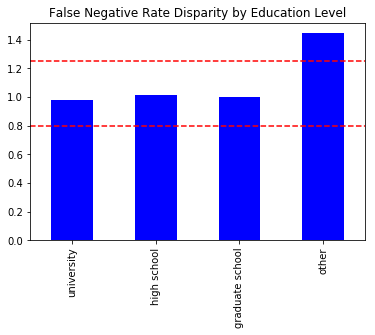

In [26]:
ax = disp_frame['False Negative Rate Disparity'].plot(kind='bar', color='b', title='False Negative Rate Disparity by Education Level')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

#### Assess and report parity
A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

* Type I Parity: Fairness in both FDR Parity and FPR Parity
* Type II Parity: Fairness in both FOR Parity and FNR Parity
* Equalized Odds: Fairness in both FPR Parity and TPR Parity
* Supervised Fairness: Fairness in both Type I and Type II Parity
* Overall Fairness: Fairness across all parities for all metrics

In [27]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=ed_levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(ed_levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['all', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
university,True,True,True,True,True,False,True,True,False,False,False,False,False,False
high school,True,True,True,True,True,True,False,True,False,False,False,True,False,False
graduate school,True,True,True,True,True,True,True,True,True,True,True,True,True,True
other,True,False,False,True,True,False,False,False,False,False,False,False,False,False
all,True,False,False,True,True,False,False,False,False,False,False,False,False,False


In general the GBM appears to have accuracy, negative predicted value, and specificity parity, but likely has a disparate impact across education levels for all other metrics. It fails to meet the criteria of overall fairness. To address such disparate impact users could tune the GBM cutoff or regularization, could try new methods for reweighing data prior to model training or try new modeling methods specifically designed for fairness. Simply dropping the variable `EDUCATION` is likely an inappropriate solution. In nonlinear models, different variables are combined by the model to represent strong signals. If a variable is important in a dataset, model, or problem domain it's likely that a nonlinear model will find combinations of other variables to act as proxies for the problematic variable -- potentially even different combinations for different rows of data!. So by simply dropping the variable from the model, you will likely not solve the disparate impact problem, but instead just make it harder to diagnose.

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models and H2OFrames, or scoring artifacts, such as POJOs and MOJOs.

In [28]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_9a0d closed.


#### Conclusion

This notebook outlines a basic approach to DIA. In a complex, real-world machine learning project the hard-to-define phenomenas of sociological bias and unfairness can materialize in many ways and from many different sources. Although far from a flawless technique, the beauty of DIA is it is straightforward to implement, functions in a model-agnostic fashion on known labels and model predictions, and is applied in complex real-world fair lending situations, so it can probably be applied to your model too!

Why risk being called out in the media for training an unfair model? Or why not investigate the monetary opportunity costs of type I errors and potential losses from type II errors? Why not do the right thing and investigate how your model treats people?